# Dataset
- Drop all rows with at least one NaN entry
- Downsample to 30Hz
- Segmentation w=100, s=12 results in 26321 train, 7891 validation and 14971 test samples
- Normalize to mean=0.5 variance=1 [reference](https://github.com/wilfer9008/Annotation_Tool_LARa/blob/2df927b55a08fbe145941a9ca1990f1550a7d3d2/From_Human_Pose_to_On_Body_Devices_for_Human_Activity_Recognition/LARA_dataset/mbientlab_dataset_preprocessing.py#L454)
- Clip to [0,1]
- Additive noise (mu=0, sigma=0.01)

In [1]:
import matplotlib.pyplot as plt
import incense
from common.helper.config import parseMongoConfig
import pandas as pd
import numpy as np

loader = incense.ExperimentLoader(**parseMongoConfig('./config.ini', adapt='IncenseExperimentLoader'))
query = {
  '$and': [
    { 'experiment.name': 'CNN-IMU_LARa' },
    { '_id': { '$gte': 97 } },
    { 'status' : 'COMPLETED'},
  ]
}
experiments = loader.find(query)
print(f'Considering Experiments: {[e.to_dict()["_id"] for e in experiments]}')

Considering Experiments: [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]


# Best Model ($\mathcal{w}F_1$)

CNN-IMU LARa id=164
test wf1  = 0.749
test acc  = 0.759
test loss = 0.744
Config: {'optimizer': 'Adam', 'max_epochs': 50, 'cnn_imu_channels': 64, 'weight_decay': 0, 'loss_patience': 32, 'sample_frequency': 30, 'lr': 0.0001, 'seed': 33780673, 'stride': 12, 'window': 100, 'betas': [0.9, 0.999], 'cnn_imu_fc_features': 512, 'validation_interval': 0.2, 'cnn_imu_weight_initialization': 'orthogonal', 'batch_size': 512, 'cnn_imu_blocks': 3}


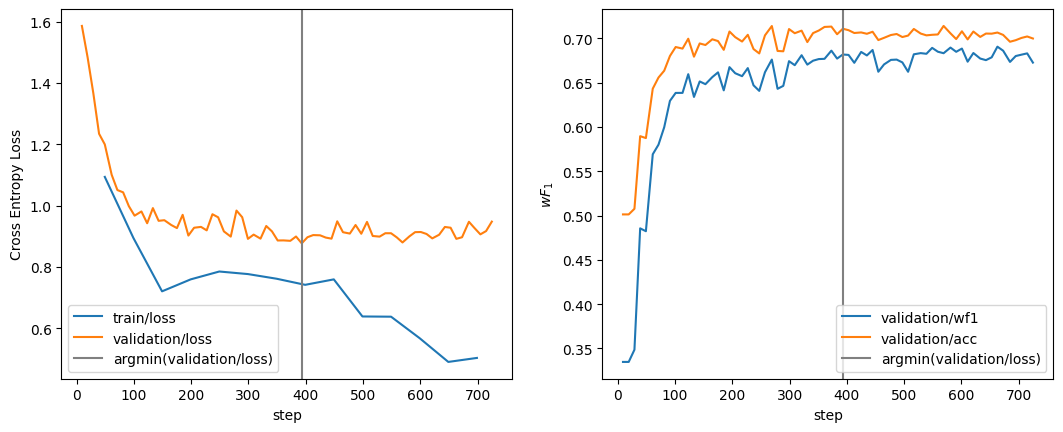

In [2]:
best_wf1 = max(experiments, key=lambda e: e.metrics['test/wf1'].values.max())

selection_ix = best_wf1.metrics['test/wf1'].argmax()
print(f'CNN-IMU LARa id={best_wf1.to_dict()["_id"]}')
print(f'test wf1  = {best_wf1.metrics["test/wf1"].values[selection_ix]:.03f}')
print(f'test acc  = {best_wf1.metrics["test/acc"].values[selection_ix]:.03f}')
print(f'test loss = {best_wf1.metrics["test/loss"].values[selection_ix]:.03f}')
print(f'Config: {best_wf1.to_dict()["config"]}')

best_val_loss_step = best_wf1.metrics['validation/loss'].idxmin()

fig, ax = plt.subplots(1,2)
fig.set_figwidth(fig.get_figwidth()*2)
best_wf1.metrics['train/loss'].plot(ax=ax[0])
best_wf1.metrics['validation/loss'].plot(ax=ax[0])
best_wf1.metrics['validation/wf1'].plot(ax=ax[1])
best_wf1.metrics['validation/acc'].plot(ax=ax[1])
ax[0].set_ylabel('Cross Entropy Loss')
ax[1].set_ylabel('$wF_1$')
for a in ax:
  a.axvline(best_val_loss_step, color='gray', label='argmin(validation/loss)')
  a.legend()
_ = fig.show()

# Batch-time statistics

Time is measured between `on_batch_start` and `on_batch_end`, this includes the transfer of the batch from RAM to the GPU.

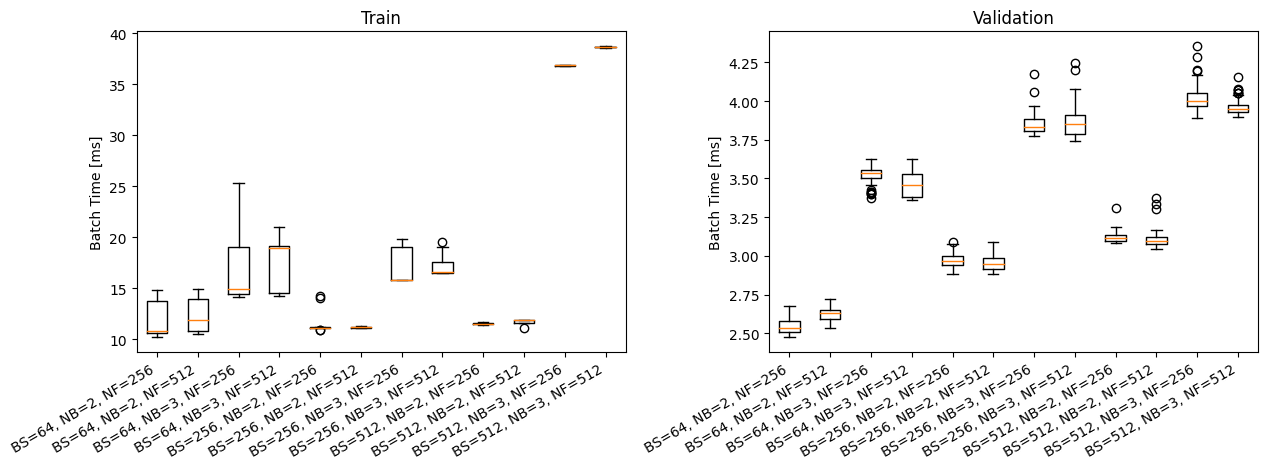

In [3]:
config_discriminators = ('batch_size', 'cnn_imu_blocks', 'cnn_imu_fc_features')
exp_by_cfg = dict(sorted({
    tuple(map(lambda c: e.to_dict()['config'][c], config_discriminators)): e for e in experiments
}.items()))

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
ax[0].boxplot(x=[e.metrics['train/batch_time'] * 1e3 for e in exp_by_cfg.values()],
              labels=[f'BS={bs}, NB={nb}, NF={nf}' for bs, nb, nf in exp_by_cfg.keys()])
ax[0].set_title(f'Train')
ax[1].boxplot(x=[e.metrics['validation/batch_time'] * 1e3 for e in exp_by_cfg.values()],
              labels=[f'BS={bs}, NB={nb}, NF={nf}' for bs, nb, nf in exp_by_cfg.keys()])
ax[1].set_title(f'Validation')
for a in ax:
  a.set_ylabel('Batch Time [ms]')
fig.autofmt_xdate()
fig.tight_layout()
